<a href="https://colab.research.google.com/github/ohmji/cnn-facial-expression-transfer-learning/blob/main/facial_expression_with_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception, VGG16, InceptionV3
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dropout, \
    Flatten, Dense, BatchNormalization, \
    SpatialDropout2D, AveragePooling2D, Input, GlobalAveragePooling2D, Activation, ZeroPadding2D, Convolution2D
import os
import cv2
import warnings
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import ceil
from sklearn import model_selection

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.get_logger().setLevel('WARNING')

In [6]:
def Xception_model(learning_rate, input_shape):
    baseModel = Xception(
        include_top=False, input_tensor=Input(shape=input_shape))
    model = Sequential()
    model.add(baseModel)
    for layer in baseModel.layers[:-7]:
        layer.trainable = False

    model.add(Flatten())

    # Fully connected neural networks
    model.add(Dense(8192, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8192, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='softmax'))
    model.compile(loss="binary_crossentropy", metrics=["accuracy"],
                  optimizer=Adam(learning_rate=learning_rate))
    return model

In [7]:
def keras_model_memory_usage_in_bytes(model, *, batch_size: int):
    """
    Return the estimated memory usage of a given Keras model in bytes.
    Ref: https://stackoverflow.com/a/64359137
    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size)
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum([tf.keras.backend.count_params(p)
                           for p in model.trainable_weights])
    non_trainable_count = sum([tf.keras.backend.count_params(p)
                               for p in model.non_trainable_weights])

    total_memory = (batch_size * shapes_mem_count + internal_model_mem_count
                    + trainable_count + non_trainable_count)
    return total_memory


In [8]:
def preprocess_data(data,labels):
    

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48
    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 3))
    for i in range(n_samples):
        image = np.fromstring(data['pixels'][i], dtype=int,
                              sep=' ').reshape((h, w, 1))
      
        X[i] = tf.image.grayscale_to_rgb(tf.convert_to_tensor(image))
      

    return X, y

In [9]:
def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown or NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y

In [10]:
def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(
        X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test

def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen

In [11]:
bs = 64
lr = 0.0001
size = (48, 48)
shape = (48, 48, 3)
epochs = 100
fileSave = "facial_expression.model"
data = pd.read_csv('/content/drive/MyDrive/colab/fer2013.csv')
labels = pd.read_csv('/content/drive/MyDrive/colab/fer2013new.csv')
print(data)
print(labels)
X, y = preprocess_data(data,labels)
X, y = clean_data_and_normalize(X, y)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
datagen = data_augmentation(x_train)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]
             Usage      Im

In [12]:
net_type_to_model = {
        'XM': Xception_model,
    }
model_name ="XM"
model_builder = net_type_to_model.get(model_name)
model = model_builder(lr, shape)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2, 2, 2048)        20861480  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 8192)              67117056  
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              67117056  
_________________________________________________________________
dropout_1 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 5

In [13]:
earlystop = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))
checkpoint = ModelCheckpoint(os.path.join("results", f"{model_name}" + f"-size-{size[0]}" +
                                              f"-bs-{bs}" + f"-lr-{lr}.h5"),
                                 monitor='val_loss', save_best_only=True, verbose=1)


In [14]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=bs), epochs=epochs,
                        steps_per_epoch=len(x_train) // bs,
                        batch_size=bs, callbacks=[
        earlystop, tensorboard, checkpoint], shuffle=True,
        validation_data=(x_val, y_val), verbose=2)
print(history)

Epoch 1/100
443/443 - 36s - loss: 0.3243 - accuracy: 0.4879 - val_loss: 0.2967 - val_accuracy: 0.5647

Epoch 00001: val_loss improved from inf to 0.29668, saving model to results/XM-size-48-bs-64-lr-0.0001.h5
Epoch 2/100
443/443 - 30s - loss: 0.2988 - accuracy: 0.5469 - val_loss: 0.2910 - val_accuracy: 0.5768

Epoch 00002: val_loss improved from 0.29668 to 0.29096, saving model to results/XM-size-48-bs-64-lr-0.0001.h5
Epoch 3/100
443/443 - 29s - loss: 0.2907 - accuracy: 0.5688 - val_loss: 0.2836 - val_accuracy: 0.5881

Epoch 00003: val_loss improved from 0.29096 to 0.28359, saving model to results/XM-size-48-bs-64-lr-0.0001.h5
Epoch 4/100
443/443 - 30s - loss: 0.2858 - accuracy: 0.5816 - val_loss: 0.2801 - val_accuracy: 0.6123

Epoch 00004: val_loss improved from 0.28359 to 0.28007, saving model to results/XM-size-48-bs-64-lr-0.0001.h5
Epoch 5/100
443/443 - 30s - loss: 0.2816 - accuracy: 0.5954 - val_loss: 0.2725 - val_accuracy: 0.6233

Epoch 00005: val_loss improved from 0.28007 to 0.

In [15]:
test_loss, test_accuracy = model.evaluate(
        x_test, y_test, batch_size=bs)
metrics = pd.DataFrame(history.history)

56/56 [==============================] - 1s 22ms/step - loss: 0.2645 - accuracy: 0.6405


In [16]:
print(metrics.head(10))

print('test_loss: ', test_loss)
print('test_accuracy: ', test_accuracy)
print('Memory consumption: %s bytes' %
          keras_model_memory_usage_in_bytes(model, batch_size=bs))

    # save_model_and_weights(model, test_accuracy)
    # model.save(model_name+'_'+fileSave, save_format="h5")

       loss  accuracy  val_loss  val_accuracy
0  0.324310  0.487926  0.296681      0.564666
1  0.298836  0.546883  0.290963      0.576782
2  0.290700  0.568841  0.283595      0.588053
3  0.285789  0.581621  0.280066      0.612285
4  0.281625  0.595425  0.272538      0.623274
5  0.276496  0.606722  0.282800      0.591152
6  0.273709  0.613959  0.269353      0.629755
7  0.270320  0.624585  0.268684      0.637644
8  0.267356  0.631363  0.264316      0.639335
9  0.266065  0.630975  0.266918      0.639053
test_loss:  0.2645392417907715
test_accuracy:  0.6404621005058289
Memory consumption: 569641815 bytes


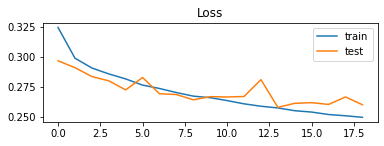

In [17]:

plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

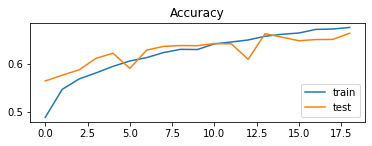

In [18]:
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()